# Data Structuring and Pruning

In [14]:
# Load datasets

import json
import pathlib
import importlib
from collections import defaultdict
import pyupset as pyu
import pandas as pd

import viccdb
%matplotlib inline

In [15]:
# reload module and load data
importlib.reload(viccdb)
vdb = viccdb.ViccDb()
vdb.report_groups()

brca: 5717 (25.3% of total)
cgi: 1073 (4.7% of total)
civic: 3340 (14.8% of total)
jax: 5754 (25.4% of total)
molecularmatch: 2085 (9.2% of total)
oncokb: 4048 (17.9% of total)
pmkb: 600 (2.7% of total)
22617 total associations


In [16]:
# for now, omit brca from analysis
brca = vdb.select(lambda x: x['source'] == 'brca')
core_vdb = vdb - brca
core_vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [17]:
# remove biological associations
oncokb_biological = core_vdb.select(lambda x: x['source'] == 'oncokb' and 'biological' in x['raw'])
oncokb_biological.report_groups(core_vdb)

oncokb: 3801 (93.9% of superset)
Total: 3801 (22.5% of superset)


In [19]:
cgi = core_vdb.select(lambda x: x['source'] == 'cgi')

## Evidence filtering

Removal of all evidence without associated publications, followed by removal of all associations without evidence.

In [253]:
def clean_refs(association):
    evidences = association['association']['evidence']
    evidence_indices_to_delete = list()
    for i, evidence in enumerate(evidences):
        assert isinstance(publications, list)
        publications = [x for x in evidence['info']['publications'] if x]
        evidence['info']['publications'] = publications
        if not publications:
            evidence_indices_to_delete.append(i)
    for index in sorted(evidence_indices_to_delete, reverse=True):
        del association['association']['evidence'][index]

map(clean_refs, core_vdb)
core_missing_ref = core_vdb.select(lambda x: not any(x.publications))
core_missing_ref.report_groups(core_vdb)
core_vdb = core_vdb - core_missing_ref

jax: 8 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
Total: 13 (0.1% of superset)


In [254]:
core_vdb.report_groups()

cgi: 1073 (8.2% of total)
civic: 3340 (25.5% of total)
jax: 5746 (43.9% of total)
molecularmatch: 2080 (15.9% of total)
oncokb: 247 (1.9% of total)
pmkb: 600 (4.6% of total)
13086 total associations


## Feature coordinate filtering

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [3]:
# Associations with more than 1 feature
x = core_vdb.select(lambda x: len(x['features']) > 1)
x.report_groups(vdb)

cgi: 231 (21.5% of superset)
civic: 1 (0.0% of superset)
jax: 1797 (31.2% of superset)
molecularmatch: 22 (1.1% of superset)
oncokb: 44 (1.1% of superset)
Total: 2095 (9.3% of superset)


In [ ]:
x.associations_by_source['civic'][0]['features'] # Multi-featured shouldn't exist

In [255]:
# Associations with coordinate features
coord_featured = core_vdb.select(lambda x: any(filter(lambda y: 'start' in y and 'end' in y, x['features'])))
coord_featured.report_groups(core_vdb)

cgi: 1069 (99.6% of superset)
civic: 3340 (100.0% of superset)
jax: 5736 (99.8% of superset)
molecularmatch: 2063 (99.2% of superset)
oncokb: 243 (98.4% of superset)
pmkb: 600 (100.0% of superset)
Total: 13051 (99.7% of superset)


### Remainder of section is inactivated code for identifying associations without coordinates

import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
remainder = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
r2 = feature_filter(fusion_re, remainder)

ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
r3 = feature_filter(ppm_re, r2)

indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
r4 = feature_filter(indel_re, r3)

bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
r5 = feature_filter(bucket_re, r4)

exon_re = re.compile(r'exon', re.IGNORECASE)
r6 = feature_filter(exon_re, r5)

expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
r7 = feature_filter(expression_re, r6)

report_groups(r7)

get_feature_names([x for x in r7 if x['source'] == 'cgi'])

# Knowledgebase Comparison

## Publications

### All publications

In [256]:
# x = core_vdb.plot_element_by_source('publications')
# f = x['figure']
# f.savefig('out/publications.pdf')

### PMIDs

In [257]:
# x = core_vdb.plot_element_by_source('publications', lambda x: x.pmid)
# f = x['figure']
# f.savefig('out/pmids.pdf')

## Genes

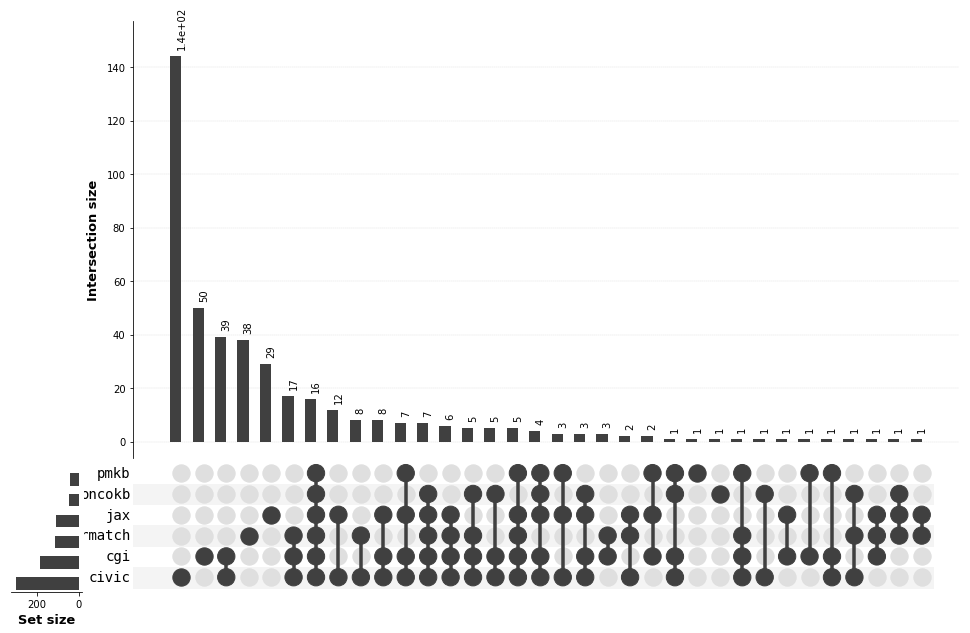

In [265]:
x = core_vdb.plot_element_by_source('genes', min_bound=1)
f = x['figure']
f.savefig('out/genes.pdf')

In [262]:
# Genes observed in all knowledgebases
gene_by_source_dict = x['input_data']
all_set_genes = set.intersection(*(gene_by_source_dict.values()))
all_set_genes

{ABL1,
 ALK,
 BRAF,
 EGFR,
 ERBB2,
 FGFR2,
 FGFR3,
 FLT3,
 KIT,
 KRAS,
 MET,
 NOTCH1,
 NRAS,
 PDGFRA,
 PIK3CA,
 PTEN}

In [44]:
# Total genes
all_genes = set.union(*(s.values()))
len(all_genes)

494

In [59]:
# >=3x coverage
count = Counter()
for source in s:
    count.update(s[source])
high_coverage_genes = [gene for gene in count if count[gene] > 3]
len(high_coverage_genes)

82

In [61]:
sorted(high_coverage_genes)

['ABL1',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK',
 'APC',
 'AR',
 'ATM',
 'AURKA',
 'BCOR',
 'BRAF',
 'BRCA1',
 'BRCA2',
 'CBL',
 'CCND1',
 'CCND2',
 'CCND3',
 'CDH1',
 'CDK4',
 'CDK6',
 'CDKN2A',
 'CDKN2B',
 'CSF1R',
 'CTNNB1',
 'DDR2',
 'DNMT3A',
 'EGFR',
 'ERBB2',
 'ERBB3',
 'ERBB4',
 'ESR1',
 'EZH2',
 'FBXW7',
 'FGF3',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FLT3',
 'FOXL2',
 'GNA11',
 'GNAQ',
 'GNAS',
 'HRAS',
 'IDH1',
 'IDH2',
 'IGF1R',
 'JAK2',
 'JAK3',
 'KDR',
 'KIT',
 'KRAS',
 'MAP2K1',
 'MET',
 'MLH1',
 'MPL',
 'MSH6',
 'MTOR',
 'MYD88',
 'NOTCH1',
 'NPM1',
 'NRAS',
 'NTRK1',
 'PDGFRA',
 'PIK3CA',
 'PTCH1',
 'PTEN',
 'RB1',
 'RET',
 'RICTOR',
 'ROS1',
 'SF3B1',
 'SMAD4',
 'SMARCB1',
 'SMO',
 'SRSF2',
 'STAG2',
 'STK11',
 'TP53',
 'TSC2',
 'U2AF1',
 'VEGFA',
 'VHL']